# Missing Data

## Script Setup

In [8]:
# Third-party and standard modules
from typing import Dict, Hashable, Tuple, Union, Optional
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from importlib import reload

# User-defined modules.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is used to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

## Script Parameters

In [9]:
filepath = './sample_data.csv'
timezone = pytz.timezone('US/Pacific')
schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries

## Preliminary Data Processing

In [10]:
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

## Missing Value Visualizations

In [11]:
def na_map_and_barchart(
    timeseries: pd.DataFrame, title: str, showcols: bool = False,
    map_filepath: Optional[str] = None, bar_filepath: Optional[str] = None,
    xlabel: str = 'access points', ylabel: str = 'time',
    figsize: Tuple[Union[int, float], Union[int, float]] = (10, 10)
) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks(timeseries.columns.to_list() if showcols else [])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    timeseries_isna = timeseries.isna()
    timeseries_isna_np = timeseries_isna.to_numpy()
    # Ensure square shape.
    ax.set_aspect(timeseries_isna_np.shape[1] / timeseries_isna_np.shape[0])
    # Show the matrix.
    ax.imshow(timeseries_isna_np, aspect='auto')
    if map_filepath is not None:
        fig.savefig(map_filepath)
    # Make barchart.
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(
        list(range(0, timeseries.shape[1])),
        dfm.column_totals(timeseries.isna())
    )
    if bar_filepath is not None:
        fig.savefig(bar_filepath)

### Missing values in the original timeseries

Gold entries in the matrix represent missing values.

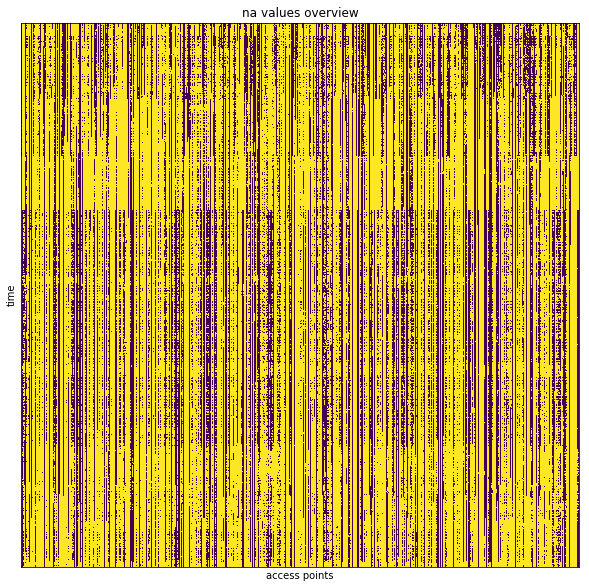

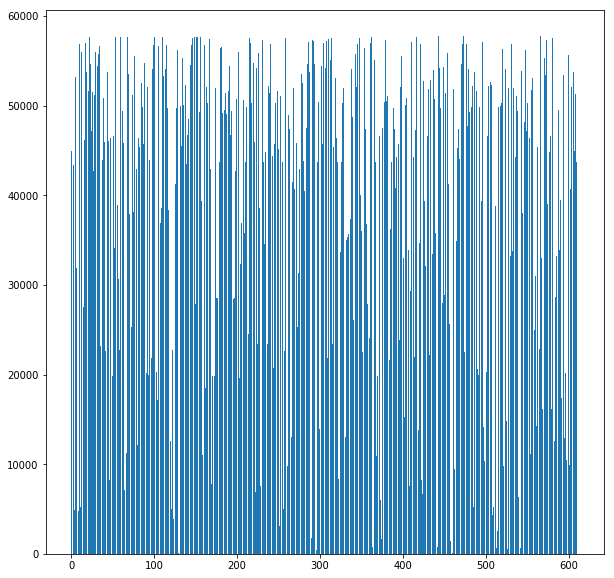

In [12]:
na_map_and_barchart(
    timeseries=occ, title='na values overview'
)

### Missing values after intervening na-values are filled

Many of our notebooks assume that intervening missing values actually represent zeros.

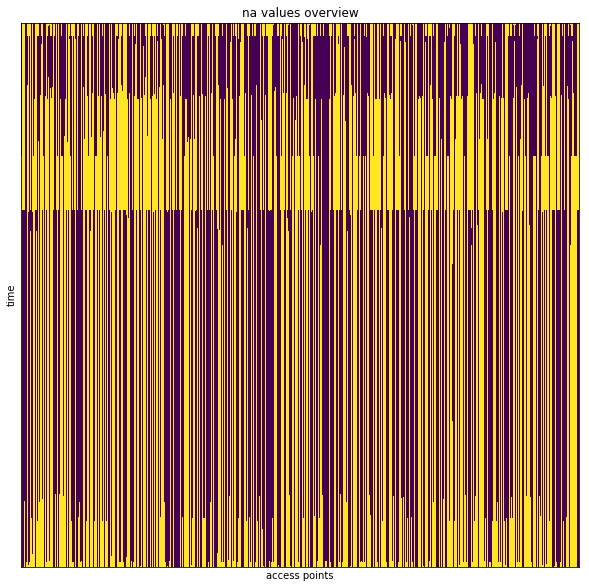

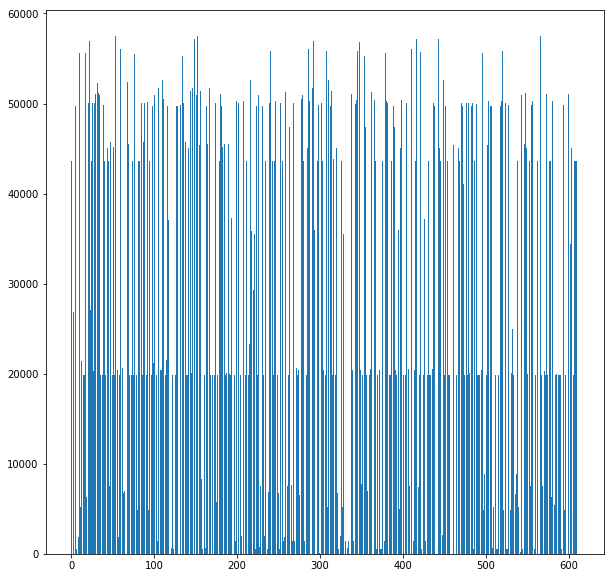

In [13]:
occ_nafilled = dfm.fill_intervening_nas(occ, inplace=False, fill_val=0)
na_map_and_barchart(
    timeseries=occ_nafilled, title='na values overview'
)

### Missing values for each building.

Let's run the previous charts again after grouping the buildings. There will likely be very few na values since a building would have to have missing values at all of its access points to have an na value here.

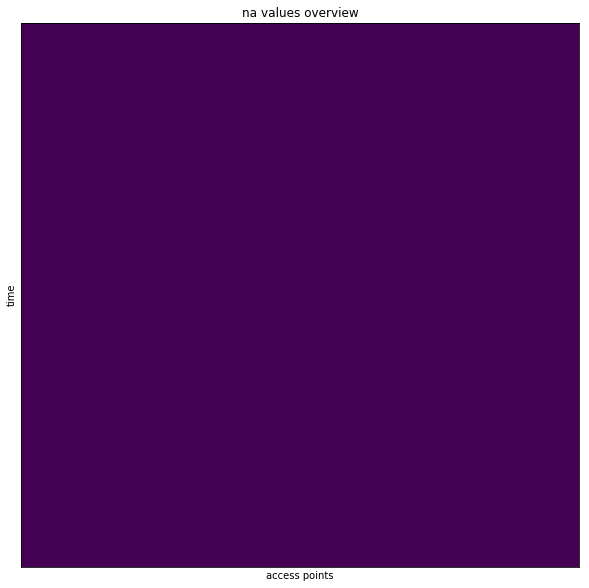

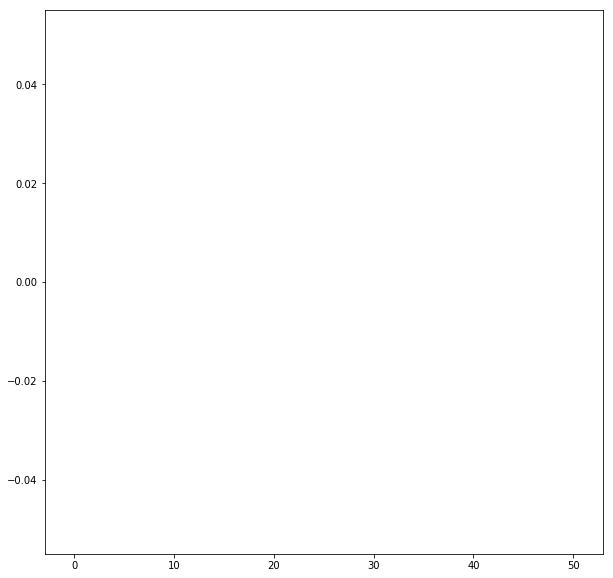

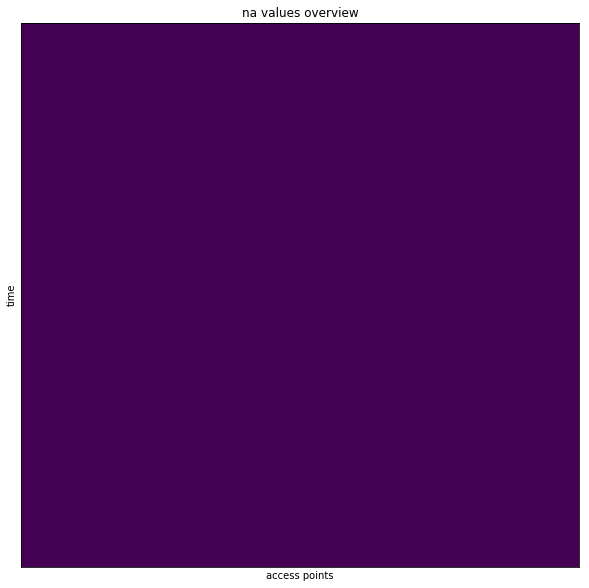

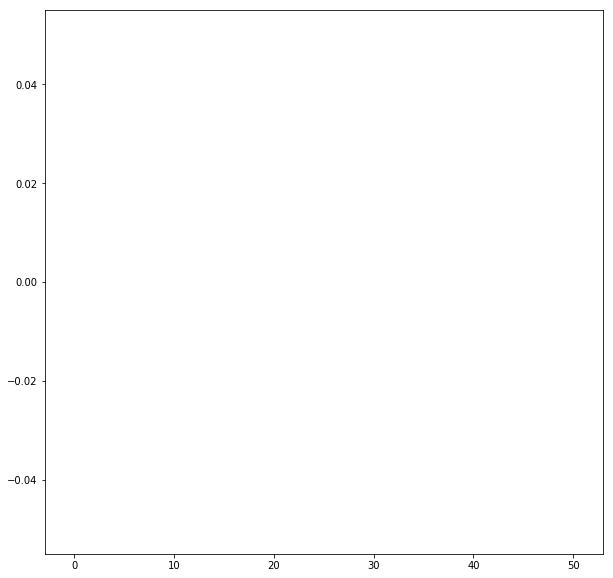

In [14]:
# Eliminate columns for access points not in the buildings we want.
occ = occ.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) is None,
    occ.columns.to_list()
)))
occ_nafilled = occ_nafilled.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) is None,
    occ_nafilled.columns.to_list()
)))

na_map_and_barchart(
    timeseries=occ.groupby(schema.col_to_building, axis=1).sum(),
    title='na values overview'
)
na_map_and_barchart(
    timeseries=occ_nafilled.groupby(schema.col_to_building, axis=1).sum(),
    title='na values overview'
)